##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# This Colab requires TF 2.5.
#!pip install -U tensorflow>=2.5

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [3]:
#!pip install tensorflow_hub

In [4]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

## Utilities

Run the following cell to create some utils that will be needed later:

- Helper method to load an image
- Map of Model Name to TF Hub handle
- List of tuples with Human Keypoints for the COCO 2017 dataset. This is needed for models with keypoints.

In [17]:
# @title Run this!!

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1'
}

IMAGES_FOR_TEST = {
    "Yoda": "D:\\Nogizaka46photo\\Yoda\\test1.jpg"
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

## Visualization tools

To visualize the images with the proper detected boxes, keypoints and segmentation, we will use the TensorFlow Object Detection API. To install it we will clone the repo.

In [18]:
# Clone the tensorflow models repository
#!git clone --depth 1 https://github.com/tensorflow/models

Intalling the Object Detection API

In [6]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  linux-gcp-5.4-headers-5.4.0-1040 linux-gcp-5.4-headers-5.4.0-1043
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libprotobuf10 libprotoc10
The following NEW packages will be installed:
  libprotobuf10 libprotoc10 protobuf-compiler
0 upgraded, 3 newly installed, 0 to remove and 104 not upgraded.
Need to get 1242 kB of archives.
After this operation, 4942 kB of additional disk space will be used.
Get:1 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libprotobuf10 amd64 3.0.0-9.1ubuntu1 [651 kB]
Get:2 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libprotoc10 amd64 3.0.0-9.1ubuntu1 [566 kB]
Get:3 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 protobuf-compiler amd64 3.0.0-9.1ubuntu1 [24.5 kB]
Fetched 1242 kB in 0s (36.4



dpkg-preconfigure: unable to re-open stdin: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


Now we can import the dependencies we will need later

In [6]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

### Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We are going, for simplicity, to load from the repository that we loaded the Object Detection API code

In [19]:
PATH_TO_LABELS = 'D:\\IA\\OCR\\Tensorflow\\models\\research\\object_detection\\data\\mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Build a detection model and load pre-trained model weights

Here we will choose which Object Detection model we will use.
Select the architecture and it will be loaded automatically.
If you want to change the model to try other architectures later, just change the next cell and execute following ones.

**Tip:** if you want to read more details about the selected model, you can follow the link (model handle) and read additional documentation on TF Hub. After you select a model, we will print the handle to make it easier.

In [20]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'CenterNet HourGlass104 Keypoints 512x512' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:CenterNet HourGlass104 Keypoints 512x512
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1


## Loading the selected model from TensorFlow Hub

Here we just need the model handle that was selected and use the Tensorflow Hub library to load it to memory.


In [11]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...


model loaded!


## Loading an image

Let's try the model on a simple image. To help with this, we provide a list of test images.

Here are some simple things to try out if you are curious:
* Try running inference on your own images, just upload them to colab and load the same way it's done in the cell below.
* Modify some of the input images and see if detection still works.  Some simple things to try out here include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).

**Be careful:** when using images with an alpha channel, the model expect 3 channels images and the alpha will count as a 4th.



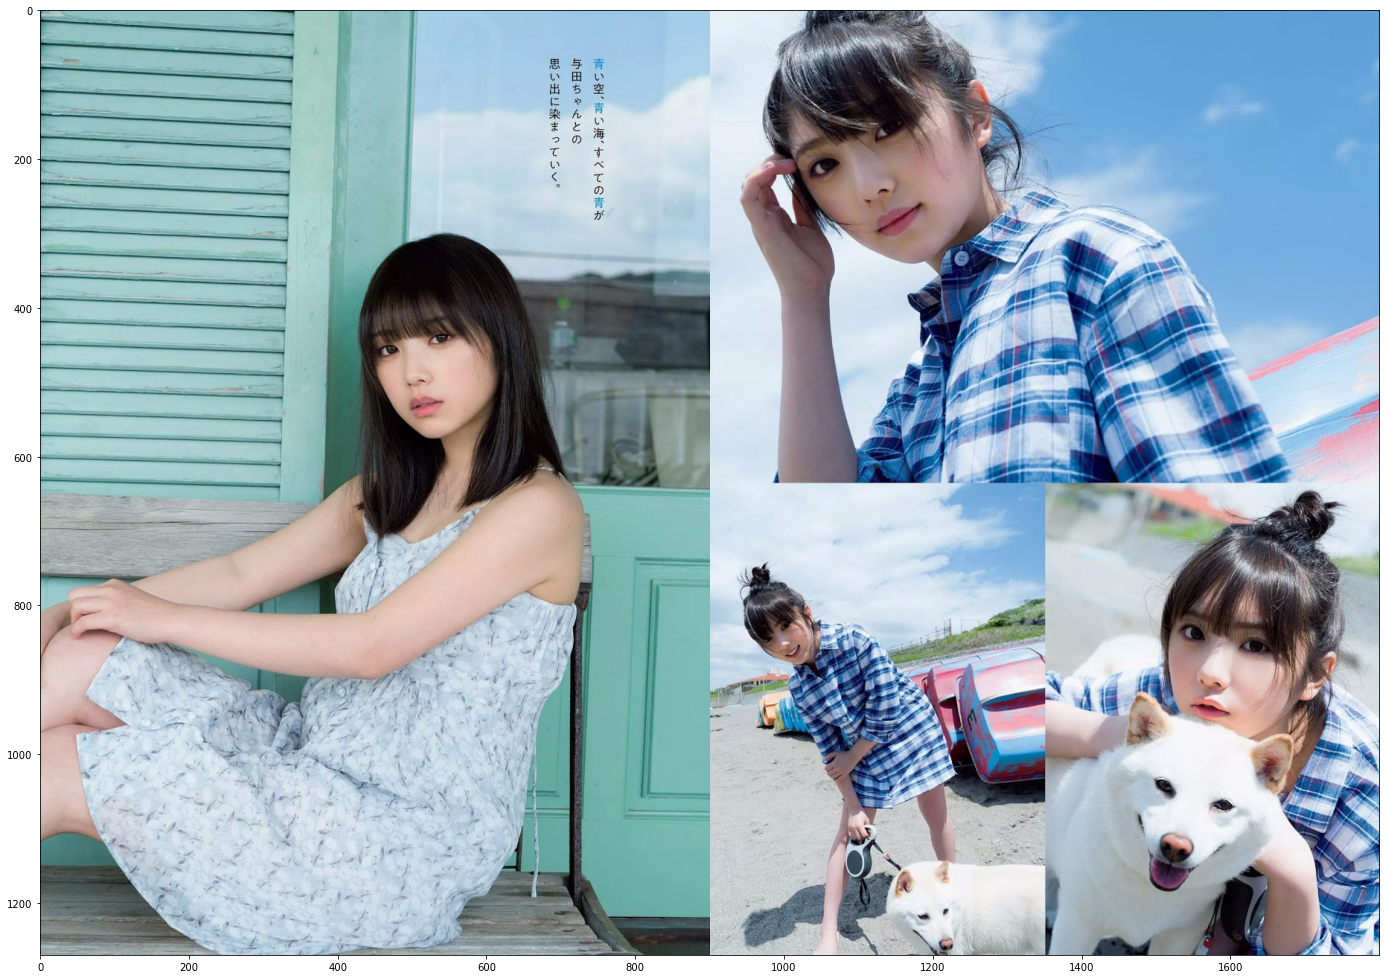

In [23]:
#@title Image Selection (don't forget to execute the cell!) { display-mode: "form"}
selected_image = 'Yoda' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

## Doing the inference

To do the inference we just need to call our TF Hub loaded model.

Things you can try:
* Print out `result['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* inspect other output keys present in the result. A full documentation can be seen on the models documentation page (pointing your browser to the model handle printed earlier)

In [24]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['detection_classes', 'detection_scores', 'detection_keypoints', 'detection_boxes', 'detection_keypoint_scores', 'num_detections'])


## Visualizing the results

Here is where we will need the TensorFlow Object Detection API to show the squares from the inference step (and the keypoints when available).

the full documentation of this method can be seen [here](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)

Here you can, for example, set `min_score_thresh` to other values (between 0 and 1) to allow more detections in or to filter out more detections.

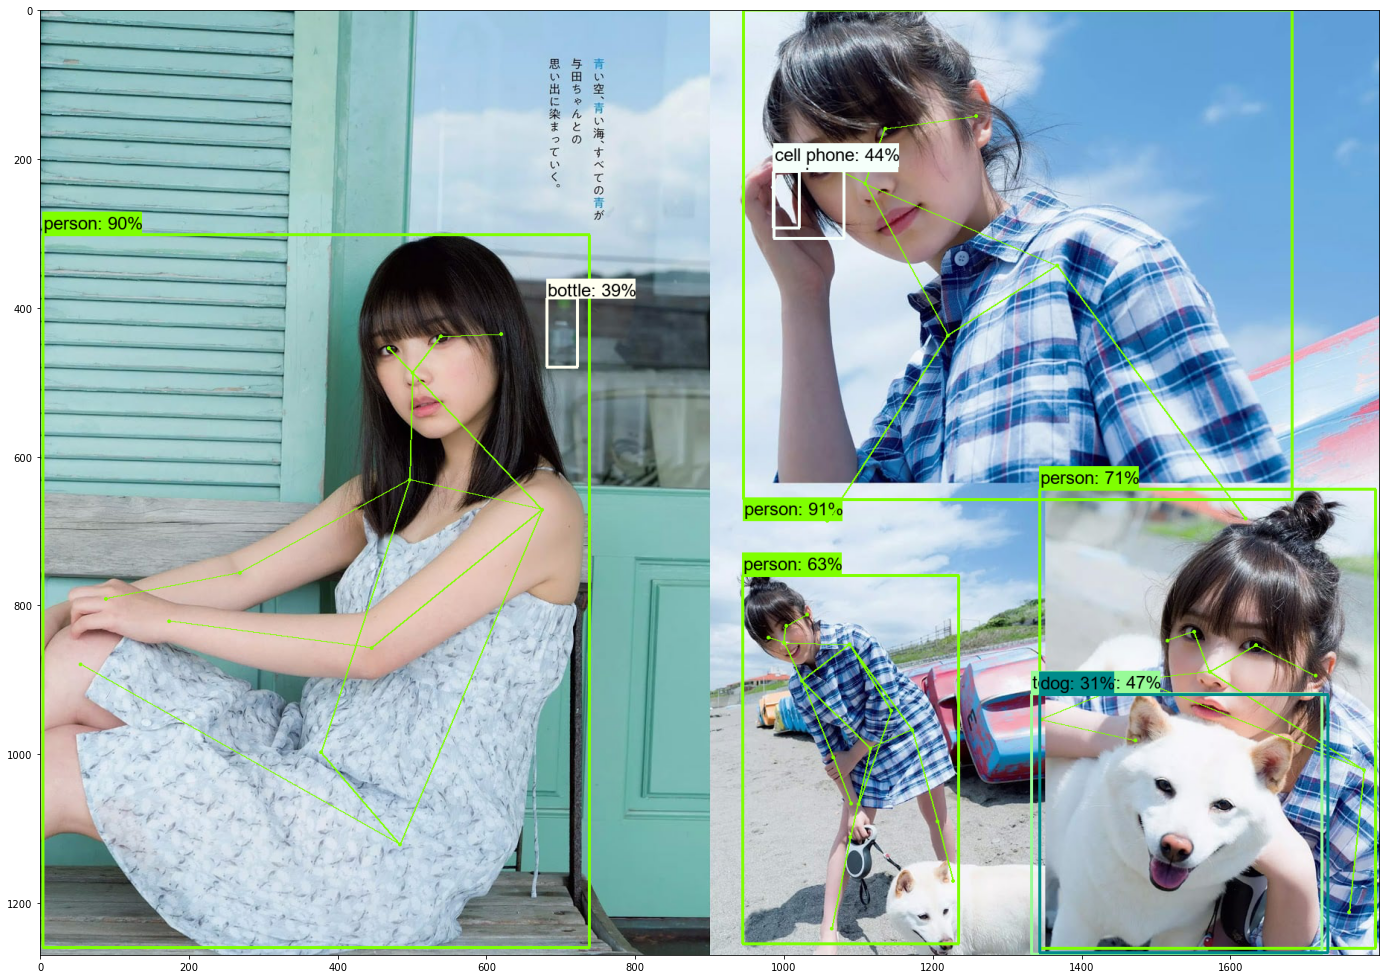

In [25]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

## [Optional]

Among the available object detection models there's Mask R-CNN and the output of this model allows instance segmentation.

To visualize it we will use the same method we did before but adding an aditional parameter: `instance_masks=output_dict.get('detection_masks_reframed', None)`


In [ ]:
# Handle models with masks:
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
  # we need to convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # Reframe the the bbox mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      tf.uint8)
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()